In [ ]:
import os 
# list(os.walk('./data'))
for i in os.walk('./data'):
    if len(i[-1]) != 0:
        for fname in i[-1]:
            print(os.path.join(i[0], fname))

./data/data283931/test.csv
./data/data283931/train.csv


In [ ]:
"""
    1. explore the data using pandas and numpy
    2. get the trend of the full data
    3. select the solutions
"""

import pandas as pd
import numpy as np
train_df = pd.read_csv('./data/data283931/train.csv', header=0)
test_df = pd.read_csv('./data/data283931/test.csv', header=0)

train_df.describe()

,dt,type,target
count,2.877305e+06,2.877305e+06,2.877305e+06
mean,2.576864e+02,3.232505e+00,3.221786e+01
std,1.429536e+02,2.832795e+00,5.035682e+01
min,1.100000e+01,0.000000e+00,-6.130000e-01
25%,1.340000e+02,1.000000e+00,1.331600e+01
50%,2.570000e+02,3.000000e+00,2.235000e+01
75%,3.810000e+02,5.000000e+00,3.443900e+01
max,5.060000e+02,1.800000e+01,1.191678e+03


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2877305 entries, 0 to 2877304
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      object 
 1   dt      int64  
 2   type    int64  
 3   target  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 87.8+ MB


<Axes: >

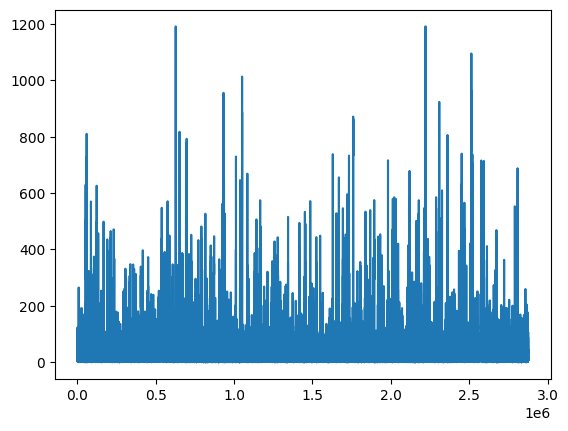

In [ ]:
# get the series of the train target and see the trend
train_tseries = train_df.loc[:, 'target']
train_tseries.plot(kind='line')

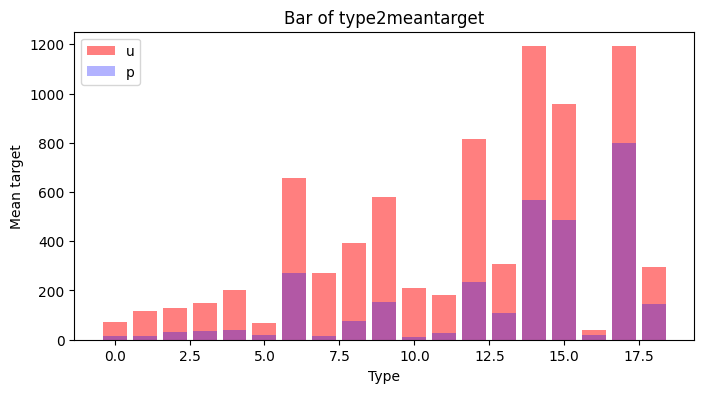

In [ ]:
import matplotlib.pyplot as plt

# groupby type and mean target
tmp_mean = train_df.groupby('type')['target'].mean().reset_index()
tmp_max = train_df.groupby('type')['target'].max().reset_index()

# create figure and plot
fig = plt.figure(figsize=(8, 4))
plt.bar(tmp_max['type'], tmp_max['target'], label='mean_target', color='red', alpha=0.5)
plt.bar(tmp_mean['type'], tmp_mean['target'], label='mean_target', color='blue', alpha=0.3)
plt.xlabel('Type')
plt.ylabel('Mean target')
plt.legend('upper right')
plt.title('Bar of type2meantarget')
plt.show()

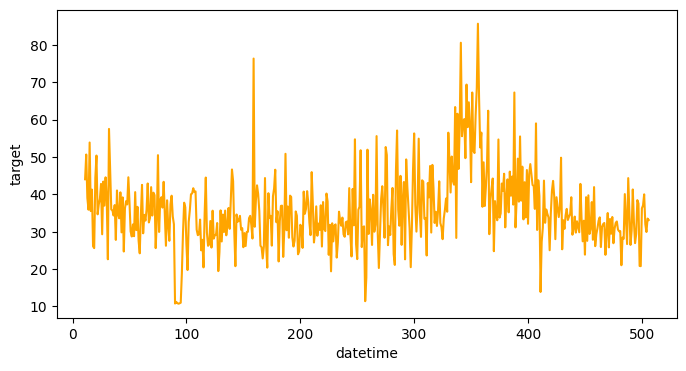

In [ ]:
# explore the specific id
tmp_00037f39cf = train_df[train_df['id'] == '00037f39cf']
tmp_00037f39cf_sorted = tmp_00037f39cf.sort_values(by='dt', ascending=True)
tmp_00037f39cf_sorted = tmp_00037f39cf_sorted.reset_index(drop=True)
plt.figure(figsize=(8,4))
plt.plot(tmp_00037f39cf_sorted['dt'], tmp_00037f39cf_sorted['target'], color='orange')
plt.xlabel('datetime')
plt.ylabel('target')
plt.show()

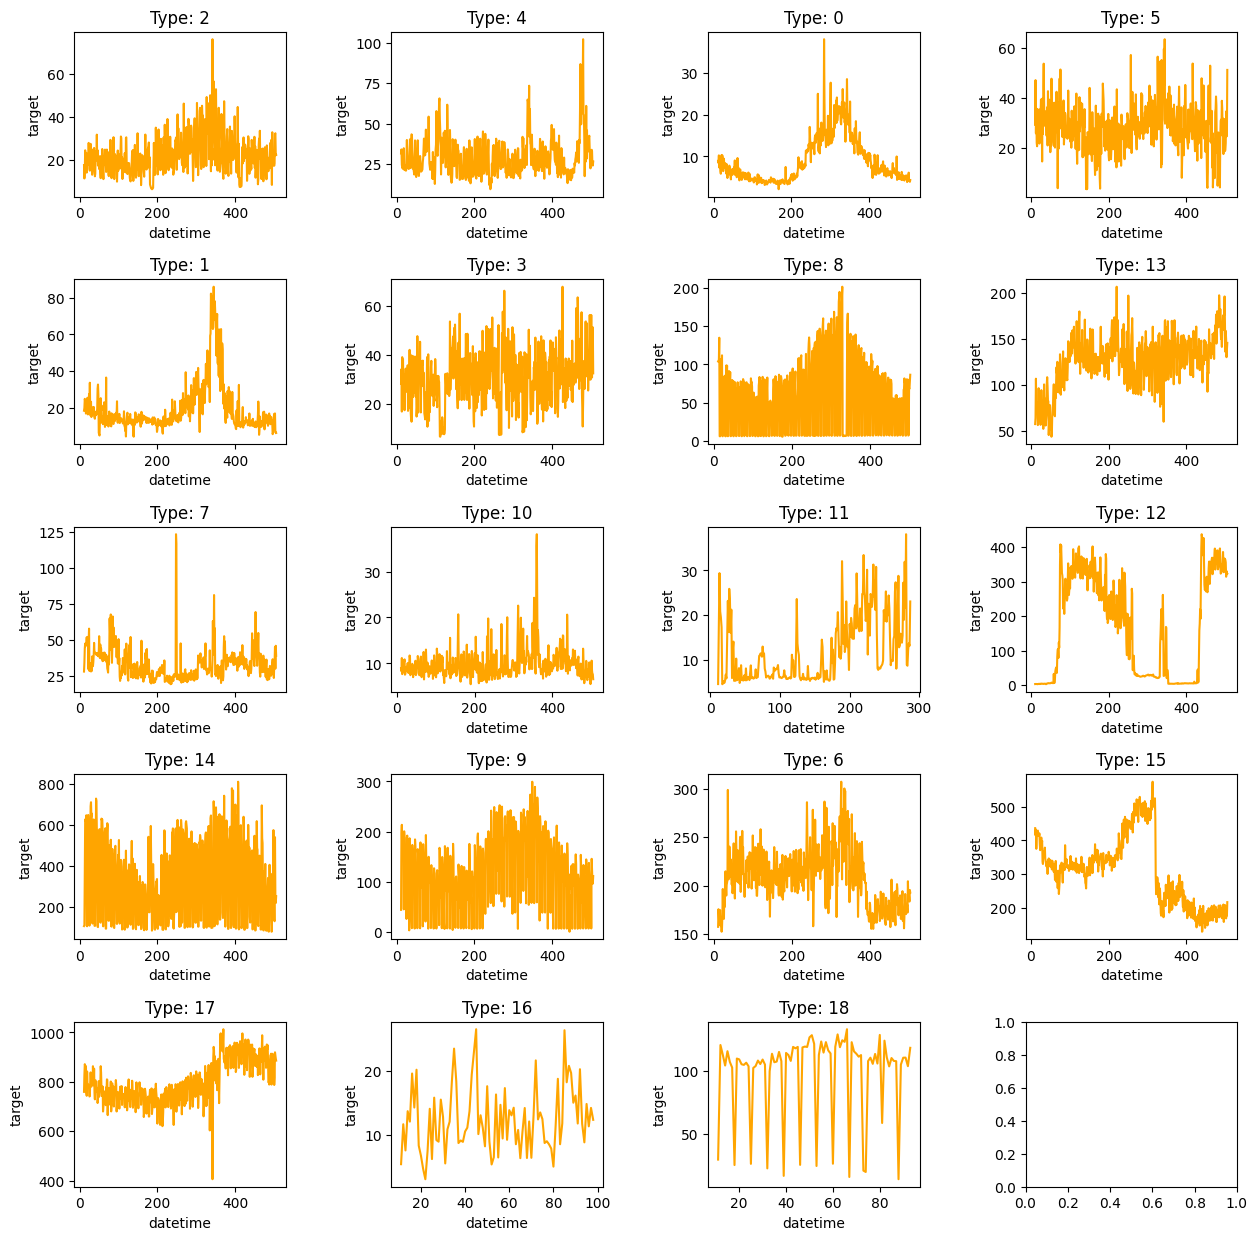

In [ ]:
# we need subplots of one example's target line each type.

# 获取所有id和type
unique_idtypes = train_df.loc[:, ['id', 'type']].drop_duplicates(subset=['id']).reset_index(drop=True)
types = unique_idtypes['type'].drop_duplicates().tolist()

# 创建子图
n_types = len(types)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
figs = axes.flatten()

for i, type_ in enumerate(types):
    ids = unique_idtypes[unique_idtypes['type'] == type_]
    random_id = ids.sample(1)['id'].values[0]
    tmp = train_df[train_df['id'] == random_id].sort_values(by='dt').reset_index(drop=True)
    figs[i].plot(tmp['dt'], tmp['target'], color='orange')
    figs[i].set_xlabel('datetime')
    figs[i].set_ylabel('target')
    figs[i].set_title(f'Type: {type_}')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.tight_layout()
plt.show()

In [ ]:
# 合并训练数据和测试数据，并进行排序
data = pd.concat([test_df, train_df], axis=0, ignore_index=True)
data = data.sort_values(['id','dt'], ascending=False).reset_index(drop=True)

# 历史平移
for i in range(10,30):
    data[f'last{i}_target'] = data.groupby(['id'])['target'].shift(i)
data
    
# 窗口统计
data[f'win3_mean_target'] = (data['last10_target'] + data['last11_target'] + data['last12_target']) / 3

# 进行数据切分
train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isnull()].reset_index(drop=True)

# # 确定输入特征
train_cols = [f for f in data.columns if f not in ['id','target']]
# train_cols

In [ ]:
!pip install lightgbm

Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
import tqdm
import sys
import os
import gc
import argparse
import warnings
warnings.filterwarnings('ignore')


def time_model(lgb, train_df, test_df, cols):
 

    # 训练集和验证集切分
    trn_x, trn_y = train_df[train_df.dt>=31][cols], train_df[train_df.dt>=31]['target']
    val_x, val_y = train_df[train_df.dt<=30][cols], train_df[train_df.dt<=30]['target']
    # 构建模型输入数据
    train_matrix = lgb.Dataset(trn_x, label=trn_y)
    valid_matrix = lgb.Dataset(val_x, label=val_y)
    # lightgbm参数
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mse',
        'min_child_weight': 5,
        'num_leaves': 2 ** 5,
        'lambda_l2': 10,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4,
        'learning_rate': 0.025,
        'seed': 2024,
        'nthread' : 16,
        'verbose' : -1,
        'early_stopping_round' : 500
        # 'verbose_eval' : 500,
    }

    # 训练模型
    model = lgb.train(lgb_params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], 
                      categorical_feature=[], callbacks=[print_evaluation(period=500)])
    
    # 打印评估回调函数
    def print_evaluation(period=1):
        def callback(env):
            if (env.iteration + 1) % period == 0:
                print(f'Iteration {env.iteration + 1}, evaluation result: {env.evaluation_result_list}')
        return callback

    # 验证集和测试集结果预测
    val_pred = model.predict(val_x, num_iteration=model.best_iteration)
    test_pred = model.predict(test_df[cols], num_iteration=model.best_iteration)
       
    # 离线分数评估
    score = mean_squared_error(val_pred, val_y)
    print(score)
    
    return val_pred, test_pred
    
lgb_oof, lgb_test = time_model(lgb, train, test, train_cols)

# 保存结果文件到本地
test['target'] = lgb_test
test[['id','dt','target']].to_csv('submit.csv', index=None)

Iteration 500, evaluation result: [('training', 'l2', 192.34290910999715, False), ('valid_1', 'l2', 189.92740126346237, False)]
Iteration 1000, evaluation result: [('training', 'l2', 181.36818819995142, False), ('valid_1', 'l2', 185.3841855788365, False)]
Iteration 1500, evaluation result: [('training', 'l2', 175.12588271488517, False), ('valid_1', 'l2', 184.22496899410484, False)]
Iteration 2000, evaluation result: [('training', 'l2', 170.5459611881833, False), ('valid_1', 'l2', 184.02657881024567, False)]
183.6860000177447
